# Dimensionality reduction & regularization methods

<div class="alert alert-block alert-warning">
  
<b>Notebook objectives:</b>
    
* Conduct PCA dimensionality reduction analysis to assess regularization potential
    
    
* Run a Lasso regression and define variables regularized
    
    
* Generate a new regularized data frame and export    

# 1. Notebook set up

In [4]:
# Try downgrading pandas version if pickle throws an error while loading
# %pip install pandas==1.4.1

In [1]:
###### Import packages

### Data handling
import numpy as np
from numpy import mean
from numpy import std
from numpy import absolute
import pandas as pd
import datetime as dt
#from IPython.display import HTML, Image #display formatted texts
import warnings
warnings.filterwarnings('ignore')

### Plotting packages
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn') # pretty graphs
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, FuncFormatter
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


### Files to pickle
import pickle
import bz2
import _pickle as cPickle

### sampling
from sklearn.model_selection import train_test_split

### sk-learn pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

### Model selection

# Models
from sklearn.linear_model import LogisticRegression, Lasso


# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

# Cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, average_precision_score, f1_score, make_scorer
from sklearn.inspection import partial_dependence

# Dimensionality reduction
from sklearn.decomposition import PCA

#Scipy stats
from scipy.stats import loguniform

# time progress bar
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
import time


# Path set up
path = "/project/data/"
path_w1 = "/project/data/w1/"
path_w2 = "/project/data/w2/"
path_w3 = "/project/data/w3/"
path_w4 = "/project/data/w4/"
path_w5 = "/project/data/w5/"
path_feature = "/project/data/feature_importance/"
json_path = "/project/notebooks/map/KEYFILE.json"

# fixed values
seed = 2323
colors = {'c1':['blue', 'red'], 'c2': ['red', 'blue', 'grey', 'purple']}
bar_width = 0.3
bin_num = 25
size = {'small_tick': 9, 'tick': 10 , 'label': 14, 'sub_title': 16, 'main_title': 20}
fig_size = {'large': (30,25), 'small': (10, 5)}

# pandas display set up
pd.options.display.max_columns = None

# 2. Loading pre-processed 'X' and 'y'

In [2]:
### Loading pickle files that will be clean and preprocess for ML modeling

# load pickled data for w1
pickled_data = bz2.BZ2File(path_w2 + 'strata_target_w2_1pct', 'rb')
sample_df = cPickle.load(pickled_data)
sample_df.drop(list(sample_df.filter(regex = 'ID')), axis = 1, inplace = True) # removes ID columns that do not hold explanatorry value
pickled_data.close()

In [3]:
# make a new reference to the data set
data = sample_df.reset_index()
print(F'Sample data set size:\n\
{data.shape[0]} rows\n\
{data.shape[1]} columns')

Sample data set size:
397979 rows
42 columns


In [4]:
# Loading X
pickled_data_X = bz2.BZ2File(path_w2 + 'X_train_dense_w2_1pct', 'rb')
X_train = cPickle.load(pickled_data_X)
pickled_data_X.close()
print(F"X_train shape: rows {X_train.shape[0]}, columns {X_train.shape[1]}")

X_train shape: rows 338282, columns 304


In [5]:
# Loading X
pickled_data_X = bz2.BZ2File(path_w2 + 'y_train_dense_w2_1pct', 'rb')
y_train = cPickle.load(pickled_data_X)
pickled_data_X.close()
print(F"X_train shape: rows {y_train.shape[0]}, columns 1")

X_train shape: rows 338282, columns 1


In [6]:
# Loading X
pickled_data_X = bz2.BZ2File(path_feature + 'X_complete_w2_1pct', 'rb')
X = cPickle.load(pickled_data_X)
pickled_data_X.close()
print(F"X_train shape: rows {X.shape[0]}, columns {X.shape[1]}")

X_train shape: rows 397979, columns 304


In [7]:
# Loading y (target)
pickled_data_y = bz2.BZ2File(path_feature + 'y_complete_w2_1pct', 'rb')
y = cPickle.load(pickled_data_y)
pickled_data_y.close()
print(F"y_train shape: rows {y.shape[0]}, columns 1")
# y_train = np.array(y_train)

y_train shape: rows 397979, columns 1


In [6]:
def clean_data_step(df):
    
    # 1. mapping features renamed
    
    # mapper to rename columns
    dict_features = {'Advertiser Currency': 'ad_currency', 'Date': 'date', 'Time of Day': 'tod', 'Advertiser': 'advertiser_name', 'Campaign': 'campaign_name', 
                    'Insertion Order': 'insertion_order', 'Line Item': 'line_item', 'Line Item Type': 'line_item_type', 'Platform': 'platform',
                    'Device Type': 'device_type', 'Device Make': 'device_make', 'Device Model': 'device_model', 'Operating System': 'os', 'Browser': 'browser',
                    'ISP or Carrier': 'isp_carrier', 'Environment': 'environment', 'Creative Type': 'creative_type', 'Creative': 'creative_name', 'Creative Size': 'creative_size',
                    'App/URL': 'app_url', 'Channel Type': 'channel_type', 'Channel': 'channel_name', 'Exchange': 'exchange', 'Inventory Source': 'inventory_source',
                    'Ad Position': 'ad_position', 'Ad Type': 'ad_type', 'Inventory Source Type': 'inventory_source_type', 'Position in Content': 'position_in_content',
                    'Public Inventory': 'public_inventory', 'Country': 'country', 'City': 'city', 'Impressions': 'impressions', 'Billable Impressions': 'billable_impressions',
                    'Active View: Viewable Impressions': 'viewable_impressions', 'Clicks': 'clicks', 'Total Conversions': 'total_conversions', 
                    'Post-Click Conversions': 'post_click_conversions', 'Post-View Conversions': 'post_view_conversions', 
                    'Revenue (Adv Currency)': 'media_cost', 'Media Cost (Advertiser Currency)': 'total_media_cost'}
    
    # rename columns to ease future referencing
    df.rename(columns = dict_features, inplace = True)
    
    # 2. Truncated instances are dropped which represent ~0.00008% fo total data set size
    df.dropna(inplace=True)
    
    # 3. Droppping unique value categorical features
    unique_v_df = pd.DataFrame(df.nunique()).rename(columns={0: "unique_values_count"})
    drop_unique_list = unique_v_df[unique_v_df['unique_values_count'] == 1].index.values.tolist()
    df.drop(drop_unique_list, axis=1, inplace = True)
    
    # 4. changing data timestamp format
    df['date'] = pd.to_datetime(df['date'])

    # 5. setting day/month/year format
    df['date'] = df['date'].dt.strftime('%d/%m/%Y')
    # return as date timestampe format
    df['date'] = pd.to_datetime(df['date'], format = "%d/%m/%Y")
    
    # 6. transforming floats to integers
    exclude_num_cols = ['media_cost','total_media_cost','index']
    float_cols = [var for var in df.select_dtypes(include=['int64', 'float64']).columns if var not in exclude_num_cols]
    
    # 7. transfor floats to int
    try:
        for col in float_cols:
            df[col] = df[col].astype('int64')
    except ValueError as excp:
        print('Make sure to pass columns with float dtype only') # friendly error message
        print(excp) # technical message as output
        print(type(excp)) # type error as output
    else:
        pass#print(F'{len(float_cols)} features tranformed to int64 dtype')
        
        
    # 8. Anonymizing data
    
    # insertion order
    insertion_orders = {n:"insertion_order{}".format(i+1) for i, n in enumerate(df['insertion_order'].unique())}
    df["insertion_order"] = df['insertion_order'].map(insertion_orders)
    
    # anonymizing line items
    line_items = {n:"line_item{}".format(i+1) for i, n in enumerate(df['line_item'].unique())}
    df["line_item"] = df['line_item'].map(line_items)
    
    # anonymizing creatives
    creatives = {n:"creative_name{}".format(i+1) for i, n in enumerate(df['creative_name'].unique())}
    df["creative_name"] = df['creative_name'].map(creatives)
    
    
    # 9. converting to string data types
    df['day_of_week'] = df['date'].dt.day_name()
    df['date'] = df['date'].dt.strftime('%d/%m/%Y')
    
    mapped_times = {n:"tod_{}".format(i+1) for i, n in enumerate(df['tod'].unique())}
    df["tod"] = df['tod'].map(mapped_times)

    
    # 10. Get the target feature
    df['user_response'] = np.where(df['clicks'] == 0, 0, 1) # generates target feature
    
    #11. log transform
    log_transform_list = ['media_cost', 'total_media_cost']
    
    for col in log_transform_list:
        df[col+'_log'] = np.log(df[col]+0.000001)
        
        df.drop([col], axis = 1, inplace = True) 
    
    
    #return cleaned df
    print(f'cleaned data set with {df.shape[0]} rows and {df.shape[1]} columns.')
    return df

In [7]:
# Defining custom cleaning step transformer
preprocessing = FunctionTransformer(clean_data_step)

In [8]:
# fitting cleaning step transformer
df_prep = preprocessing.fit_transform(data)

cleaned data set with 397979 rows and 31 columns.


# 3. Dimensionality Reduction

In [10]:
#Fitting PCA
data_pca = X

pca = PCA()
pca.fit(data_pca)
cumsum = np.cumsum(pca.explained_variance_ratio_) #for cumulative explained variance
d = np.argmax(cumsum >= 0.95) + 1 #0.95 explained variance dimension

#Used for covar matrix in appendix
components = ['Components{}'.format(i) for i in range(len(pca.components_))] 
data_pca = pd.DataFrame(data = pca.components_,
                        columns = data_pca.columns,
                        index = components)

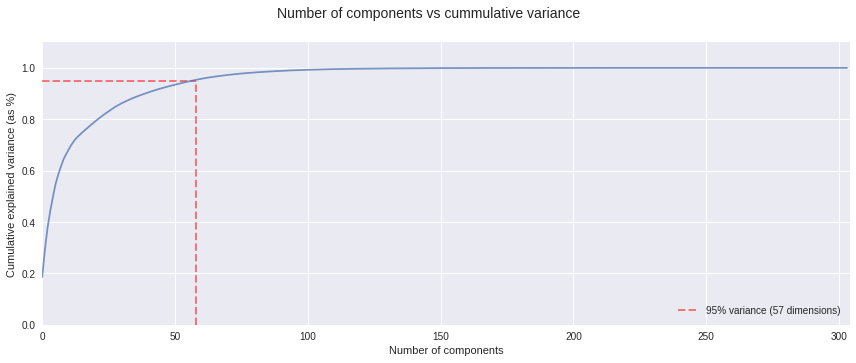

In [14]:
#### Explained variance PCA

#### set up fig and axes

fig, ax = plt.subplots(1,1, figsize=(12, 5))
# fig.set_size_inches(50, 25)

ax1 = ax

#### Plotting cummulative sum of explanied variance
num_feature = cumsum.shape[0]

ax1.plot(cumsum, alpha=0.75)
ax1.vlines(x=d, ymin = 0, ymax = 0.95 , colors= colors["c2"][0], ls='--', alpha=0.5, lw=2, label='95% variance (57 dimensions)') # ymin = -0.8, ymax = 1.5,
ax1.hlines(y=0.95, xmin = 0, xmax = d , colors= colors["c2"][0], ls='--', alpha=0.5, lw=2) # ymin = -0.8, ymax = 1.5,
ax1.set_ylim(0, 1.1)
ax1.set_xlim(0, cumsum.shape[0])

ax1.set_xlabel('Number of components')
ax1.set_ylabel('Cumulative explained variance (as %)')
# ax1.set_title("Cumulative explained variance percentage by dimension", 
#                      fontsize =  size["sub_title"])

ax1.legend(loc = 'lower right', fontsize = 10)


### figure set up
fig.suptitle('Number of components vs cummulative variance', fontsize = 14,  y = 0.99999)
plt.tight_layout(w_pad=2.5, h_pad=0.1)
plt.show()

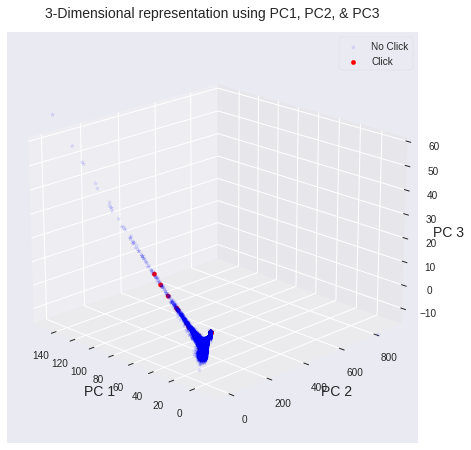

In [64]:
#### 3D projection
from mpl_toolkits.mplot3d import Axes3D


# fig, ax = plt.subplots(1,1, figsize=(20, 5))

fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(111, projection='3d')

### Defining x, y, and z dimension (PC1, PC2 and PC3)
proyection = pca.transform(X_train)

x=proyection[:,0]
y=proyection[:,1]
z=proyection[:,2]

cdict = {0:'blue',1:'red'}
labl = {0:'No Click',1:'Click'}
marker = {0:'*',1:'o'}
alpha = {0: 0.1, 1: 1}

# fig.patch.set_facecolor('white')
for l in np.unique(y_train):
    ix=np.where(y_train == l)
    ax.scatter(x[ix], y[ix], z[ix], c=cdict[l], label=labl[l], marker=marker[l], alpha=alpha[l])
    
# for loop ends
ax.view_init(200, 45) #(-145,45)
ax.set_xlabel("PC 1", fontsize=14)
ax.set_ylabel("PC 2", fontsize=14)
ax.set_zlabel("PC 3", fontsize=14)
ax.set_zlim(60, -15)
ax.legend(loc = 'upper right', frameon = True)

fig.suptitle('3-Dimensional representation using PC1, PC2, & PC3', fontsize = 14,  y = 0.88)
fig.tight_layout(w_pad=2.5, h_pad=2.5)
plt.show()

# 4. Regularization

### 4.1 Lasso Regression regularization

In [34]:
def lasso_regularization(X,y):

    parameters = np.arange(1,10,1) #range for penalty weight factor
    obj_function = []
    var_list  = []

    for c in parameters:
        #print(c)
        clf = LogisticRegression(penalty = 'l1', max_iter=10, solver='liblinear', C = c, random_state=seed) #fitting log regression for regularization
        clf.fit(X,y)
        weights = np.array(clf.coef_) #weights of log regression
        features = X.columns.tolist()
        coeffs_regularized = np.where(weights[0] == 0) #mark penalized coefficients
        y_predict = clf.predict_proba(X)[:,1] # get predictions for each fold
        y_predict_v = clf.predict(X) # true target values
        y_pre = clf.predict(X)
        #recall = recall_score(y_target, y_predict_v, average='macro') #target function for regularization
        auc = roc_auc_score(y, y_predict)#, average='macro')
        obj_function.append(auc)
        var_list.append(coeffs_regularized)

    max_score = np.argmax(obj_function) # best accuracy score from target function
    optimum = round(parameters[max_score],2) #best penalty weight factor
    feature_dump = var_list[max_score] #list of features to drop

    # Define dataframes for features regularized

    feature_importance = {'feature': features, 'weight': weights[0]}
    feature_importance_df = pd.DataFrame(feature_importance)
    top_pos_features = feature_importance_df.sort_values(by = ['weight'], ascending = False)
    top_neg_features = feature_importance_df.sort_values(by = ['weight'], ascending = True)
    regularized_features = feature_importance_df[feature_importance_df['weight'] == 0]

    print(F"Optimum penalty factor: {optimum}\n")
    print(F"Number of fearures to drop: {len(feature_dump[0])}\n")

    return feature_importance_df, top_pos_features, top_neg_features, regularized_features, feature_dump, obj_function

In [35]:
# Run lasso regression
features_weights, top_features, neg_features, regularized_features, feature_dump, obj_function = lasso_regularization(X,y)

Optimum penalty factor: 8

Number of fearures to drop: 115



In [36]:
obj_function

[0.7547073473753013,
 0.7643578761150485,
 0.7663439367564492,
 0.770675981972689,
 0.7710596748231345,
 0.771109218512664,
 0.7730890920785998,
 0.7738953518244208,
 0.7674304324104666]

In [17]:
# load pickled regularized
pickled_data = bz2.BZ2File(path_feature + 'X_train_regularized_w2_1pct', 'rb')
X_regularized_train = cPickle.load(pickled_data)
pickled_data.close()

# load pickled regularized
pickled_data = bz2.BZ2File(path_feature + 'y_train_regularized_w2_1pct', 'rb')
y_regularized_train = cPickle.load(pickled_data)
pickled_data.close()

# load pickled regularized
pickled_data = bz2.BZ2File(path_feature + 'X_test_regularized_w2_1pct', 'rb')
X_regularized_test = cPickle.load(pickled_data)
pickled_data.close()

# load pickled regularized
pickled_data = bz2.BZ2File(path_feature + 'y_test_regularized_w2_1pct', 'rb')
y_regularized_test = cPickle.load(pickled_data)
pickled_data.close()

In [10]:
### Defining a new data frame to plot regularization outputs
top_plot = top_features[:21] # top 20 positive features
bottom_plot = neg_features[:21] # top 20 negative features
top_20 = pd.concat([top_plot, bottom_plot], axis=0) # merge into a new df
top_20['dimension'] = top_20['feature'].apply(lambda x: x[:x.find('_')]) # str handling
top_20['category'] = top_20['feature'].apply(lambda x: x[x.find('_')+1:])

# define a mapper for feature names
dict_features = {'ad': 'ad_currency', 'date': 'date', 'tod': 'tod', 'advertiser': 'advertiser_name', 'campaign': 'campaign_name', 
                'insertion': 'insertion_order', 'line': 'line_item', 'platform': 'platform',
                'device': 'device_make',  'os': 'os', 'browser': 'browser',
                'isp': 'isp_carrier', 'environment': 'environment', 'creative': 'creative',
                'app': 'app_url', 'channel': 'channel', 'exchange': 'exchange', 'inventory': 'inventory',
                'public_inventory': 'inventory', 'country': 'country', 'city': 'city', 'impressions': 'impressions', 
                'billable': 'impressions',
                'viewable': 'impressions', 'clicks': 'clicks', 'total': 'conversions', 
                'post': 'post_conversion',
                'media': 'cost'}

# solve string and computing absolute number weights
top_features['split'] = top_features['feature'].apply(lambda x: x.split("_"))
top_features['dimension'] = top_features['feature'].apply(lambda x: x[:x.find('_')])
top_features['category'] = top_features['feature'].apply(lambda x: x[x.find('_')+1:])
top_features['dimension_grouped'] = top_features['dimension'].map(dict_features)
top_features['pred_pwr'] = top_features['weight'].apply(lambda x: abs(x)) # getting absolute number weights

#### Absolute value contribution per feature

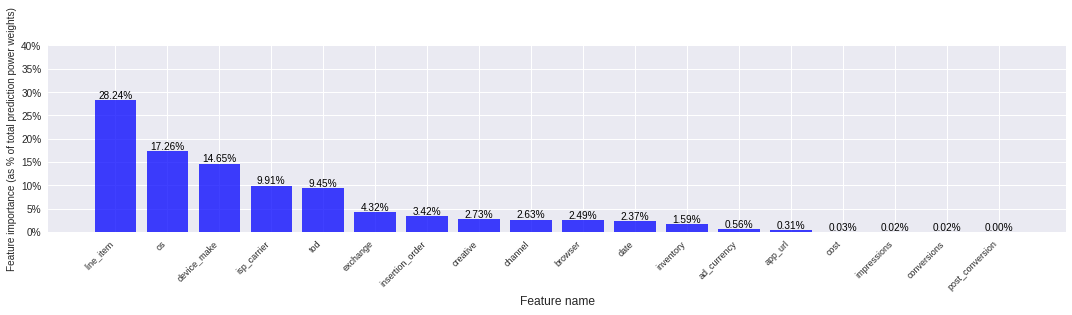

In [11]:
##### Plot distributions

group_dimensions = pd.DataFrame(top_features.groupby('dimension_grouped')['pred_pwr'].sum()).reset_index()
group_dimensions['share_pred_pwr'] = group_dimensions['pred_pwr']/ group_dimensions['pred_pwr'].sum()
group_dimensions.sort_values(by = 'share_pred_pwr', ascending =  False, inplace = True)

fig, ax = plt.subplots(1, 1, figsize = (15, 4)) # Create figure and axes # , sharex = True

xticks = group_dimensions['dimension_grouped']
yticks = mticker.FormatStrFormatter('%.f%%')
x_axis = range(len(xticks))


# top features 
ax.bar(x_axis, group_dimensions['share_pred_pwr']*100, color = 'b', alpha = 0.75)

ax.set_xticks(ticks = x_axis)
ax.set_xticklabels(xticks, rotation = 45, fontsize = size['small_tick'], horizontalalignment = 'right')

ax.set_xlabel('Feature name', fontsize = 12) # Set label of scale distribution
ax.set_ylabel('Feature importance (as % of total prediction power weights)', fontsize = 10) # Set axis label
ax.yaxis.set_major_formatter(yticks)
ax.set_ylim(0, 40)

for i, v in enumerate(group_dimensions['share_pred_pwr'].array*100):
    ax.text(i, v + 1,
            f"{group_dimensions['share_pred_pwr'].array[i]*1:,.2%}", 
            color = 'black',
            fontsize = size['tick'],
            ha = 'center', va = 'center')


fig.tight_layout(w_pad=2.5, h_pad=1.5)
plt.show()

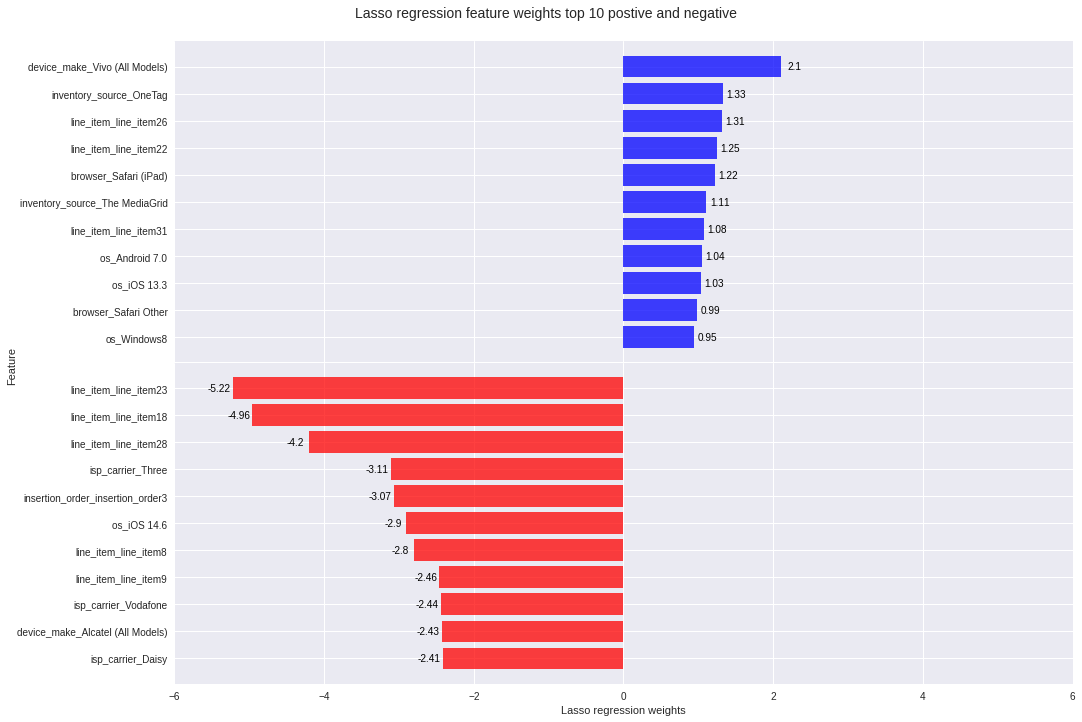

In [12]:
##### Plot most top 20 positive and negative weight categorized features

top_plot = top_features[:11]
bottom_plot = neg_features[:11]
top_20 = pd.concat([top_plot, bottom_plot], axis=1)

fig, ax = plt.subplots(2, 1, figsize = (15, 10), sharex = True) # Create figure and axes # , sharex = True

ax1 = ax.flat[0]
ax2 = ax.flat[1]

# top features 
ax1.barh(top_plot['feature'], # Input for the values of each feature   # ax1.barh
        top_plot['weight'], # Input for the distribution of each value
        color = 'b',
        alpha = 0.75)

#ax1.set_xlabel('Lasso regression weights', fontsize = size['label']) # Set label of scale distribution
#ax1.set_ylabel('features', fontsize = 11) # Set axis label
ax1.set_xlim(0, 6)
ax1.invert_yaxis()

# add labels top features
for i, v in enumerate(top_plot['weight']): # Defines the position of the text within each subplot

    ax1.text(v + 0.18, i, # Coordinates of the text relative to the bar length
        round(top_plot['weight'].array[i],2), # Label (text) to display
        color = 'black',
        fontsize = size['tick'],
        ha = 'center', va = 'center') # Alignment of the text

# bottom features
ax2.barh(bottom_plot['feature'], # Input for the values of each feature   # ax2.barh
        bottom_plot['weight'], # Input for the distribution of each value
        color = 'r',
        alpha = 0.75)
ax2.set_xlabel("Lasso regression weights", fontsize = 11) # Set label of scale distribution
#ax2.set_ylabel('features', fontsize = 11) # Set axis label
ax2.set_xlim(-6, 6)
ax2.invert_yaxis()

# add labels bottom features
for i, v in enumerate(bottom_plot['weight']): # Defines the position of the text within each subplot

    ax2.text(v - 0.18, i, # Coordinates of the text relative to the bar length
        round(bottom_plot['weight'].array[i],2), # Label (text) to display
        color = 'black',
        fontsize = size['tick'],
        ha = 'center', va = 'center') # Alignment of the text

fig.text(0.001, 0.5, 'Feature', va='center', rotation='vertical', fontsize = 11)
fig.suptitle('Lasso regression feature weights top 10 postive and negative', fontsize = 14,  y = 0.999)
plt.tight_layout(w_pad=2.5, h_pad=0.009)
plt.show()

In [19]:
top_features['weight']

122    2.103838
285    1.330946
58     1.313935
54     1.245581
195    1.223532
         ...   
40    -3.066216
238   -3.107455
60    -4.202820
49    -4.962893
55    -5.218652
Name: weight, Length: 304, dtype: float64

In [21]:
top_features

,feature,weight,split,dimension,category,dimension_grouped,pred_pwr
122,device_make_Vivo (All Models),2.103838,"[device, make, Vivo (All Models)]",device,make_Vivo (All Models),device_make,2.103838
285,inventory_source_OneTag,1.330946,"[inventory, source, OneTag]",inventory,source_OneTag,inventory,1.330946
58,line_item_line_item26,1.313935,"[line, item, line, item26]",line,item_line_item26,line_item,1.313935
54,line_item_line_item22,1.245581,"[line, item, line, item22]",line,item_line_item22,line_item,1.245581
195,browser_Safari (iPad),1.223532,"[browser, Safari (iPad)]",browser,Safari (iPad),browser,1.223532
...,...,...,...,...,...,...,...
40,insertion_order_insertion_order3,-3.066216,"[insertion, order, insertion, order3]",insertion,order_insertion_order3,insertion_order,3.066216
238,isp_carrier_Three,-3.107455,"[isp, carrier, Three]",isp,carrier_Three,isp_carrier,3.107455
60,line_item_line_item28,-4.202820,"[line, item, line, item28]",line,item_line_item28,line_item,4.202820
49,line_item_line_item18,-4.962893,"[line, item, line, item18]",line,item_line_item18,line_item,4.962893


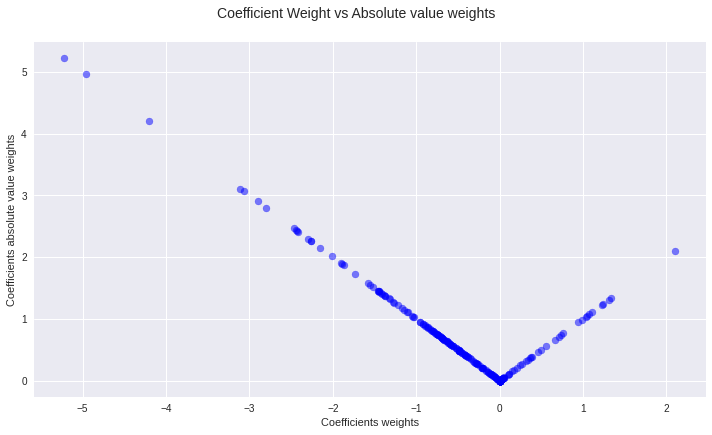

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6), sharex = True) # Create figure and axes # , sharex = True

# ax1 = ax.flat[0]
# ax2 = ax.flat[1]

# top features 
ax.scatter(top_features['weight'], # Input for the values of each feature   # ax1.barh
        top_features['pred_pwr'], # Input for the distribution of each value
        color = 'b',
        alpha = 0.5)
ax.set_xlabel("Coefficients weights", fontsize = 11) # Set label of scale distribution
ax.set_ylabel("Coefficients absolute value weights", fontsize = 11) # Set label of scale distribution

fig.suptitle('Coefficient Weight vs Absolute value weights', fontsize = 14,  y = 0.999)
plt.tight_layout(w_pad=2.5, h_pad=0.009)
plt.show()

In [132]:
def dimension_plot_deepdive(dimension):
    ##### Plot most top 20 positive and negative weight categorized features
    pos_features = top_features.sort_values(by = ['weight'], ascending = False)
    neg_features = top_features.sort_values(by = ['weight'], ascending = True)

    top_plot = pos_features[(pos_features['dimension_grouped'] == dimension) & (pos_features['weight']>0) & (pos_features['weight']>0.1)][:10]
    bottom_plot = neg_features[(neg_features['dimension_grouped'] == dimension) & (neg_features['weight']<0)][:10]
    top_20 = pd.concat([top_plot, bottom_plot], axis=1)

    fig, ax = plt.subplots(2, 1, figsize = (15, 10), sharex = True) # Create figure and axes # , sharex = True

    ax1 = ax.flat[0]
    ax2 = ax.flat[1]

    # top features 
    ax1.barh(top_plot['feature'], # Input for the values of each feature   # ax1.barh
            top_plot['weight'], # Input for the distribution of each value
            color = 'b',
            alpha = 0.75)

    #ax1.set_xlabel('Lasso regression weights', fontsize = size['label']) # Set label of scale distribution
    #ax1.set_ylabel('features', fontsize = 11) # Set axis label
    ax1.set_xlim(0, 6)
    ax1.invert_yaxis()

    # add labels top features
    for i, v in enumerate(top_plot['weight']): # Defines the position of the text within each subplot

        ax1.text(v + 0.18, i, # Coordinates of the text relative to the bar length
            round(top_plot['weight'].array[i],2), # Label (text) to display
            color = 'black',
            fontsize = size['tick'],
            ha = 'center', va = 'center') # Alignment of the text

    # bottom features
    ax2.barh(bottom_plot['feature'], # Input for the values of each feature   # ax2.barh
            bottom_plot['weight'], # Input for the distribution of each value
            color = 'r',
            alpha = 0.75)
    ax2.set_xlabel("Lasso regression weights", fontsize = 11) # Set label of scale distribution
    #ax2.set_ylabel('features', fontsize = 11) # Set axis label
    ax2.set_xlim(-6, 6)
    ax2.invert_yaxis()

    # add labels bottom features
    for i, v in enumerate(bottom_plot['weight']): # Defines the position of the text within each subplot

        ax2.text(v - 0.18, i, # Coordinates of the text relative to the bar length
            round(bottom_plot['weight'].array[i],2), # Label (text) to display
            color = 'black',
            fontsize = size['tick'],
            ha = 'center', va = 'center') # Alignment of the text

    fig.text(0.001, 0.5, 'Feature', va='center', rotation='vertical', fontsize = 11)
    fig.suptitle(F'Top categories weights impacting {dimension} ', fontsize = 14,  y = 0.999)
    plt.tight_layout(w_pad=2.5, h_pad=0.009)
    plt.show()

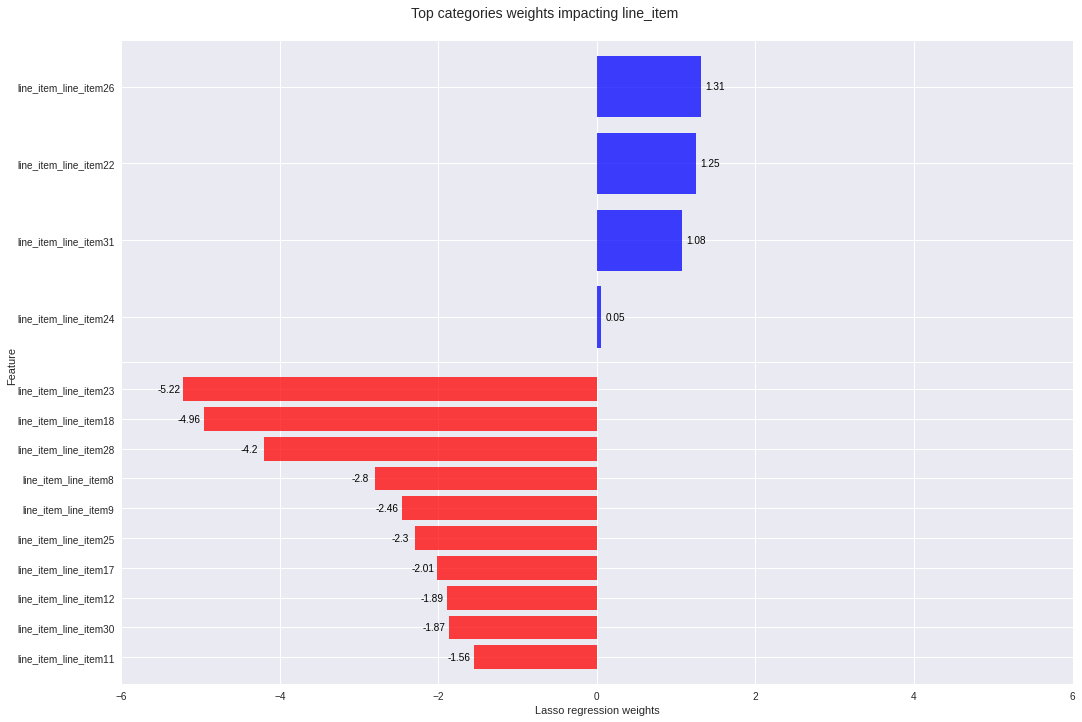

In [128]:
dimension_plot_deepdive('line_item')

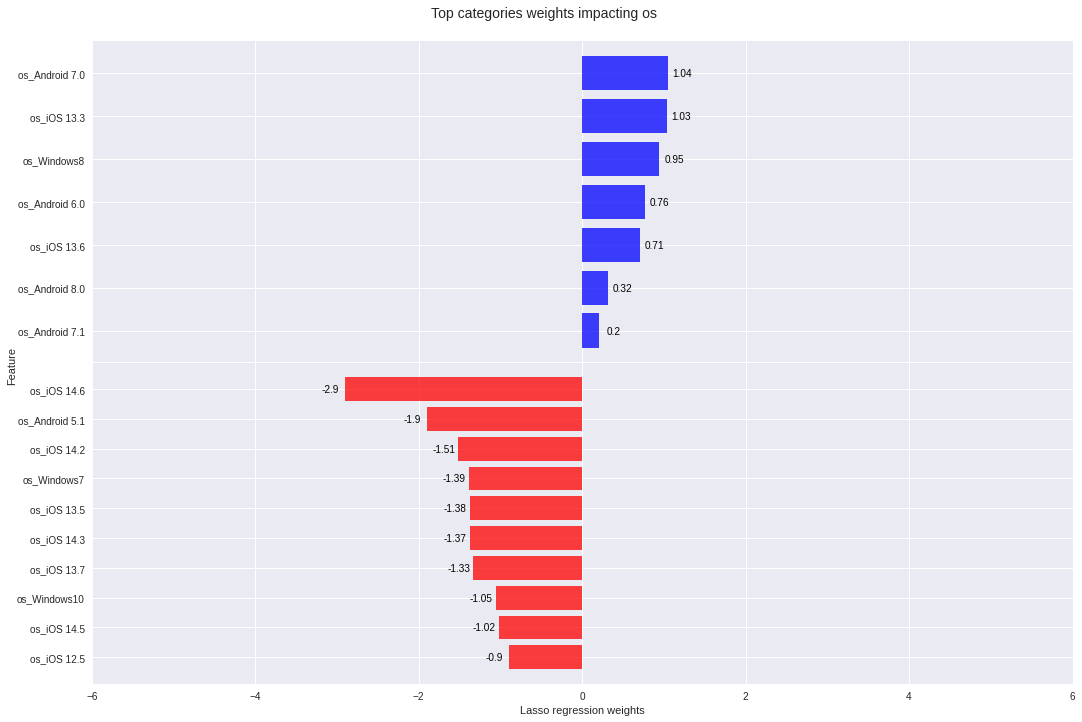

In [133]:
dimension_plot_deepdive('os')

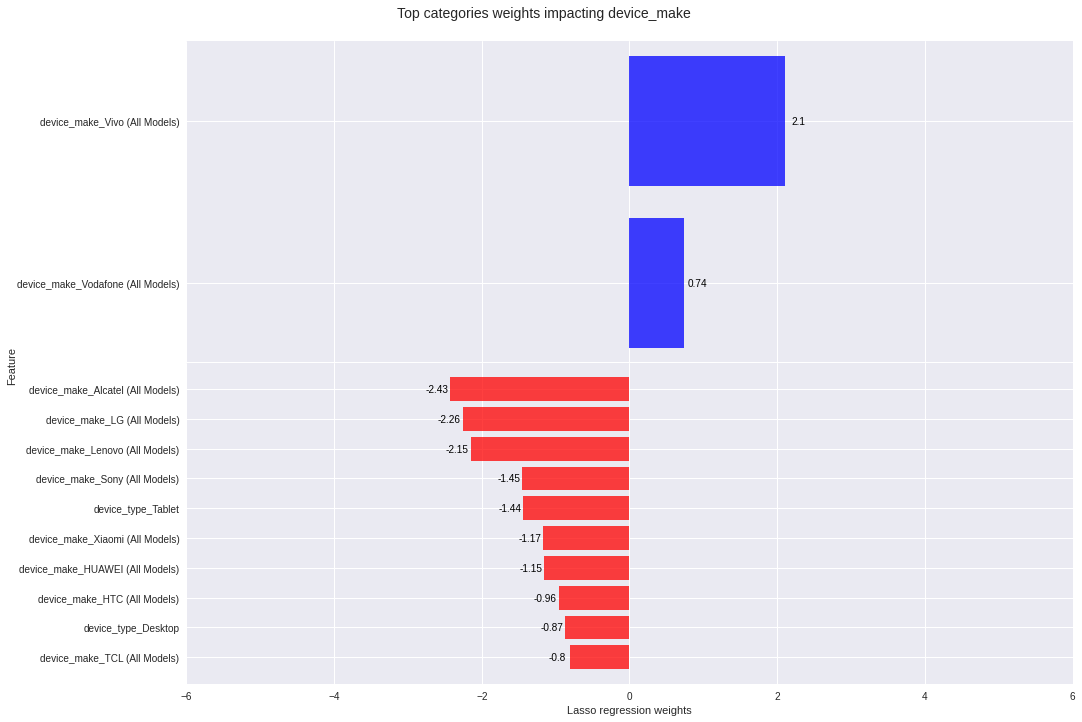

In [134]:
dimension_plot_deepdive('device_make')

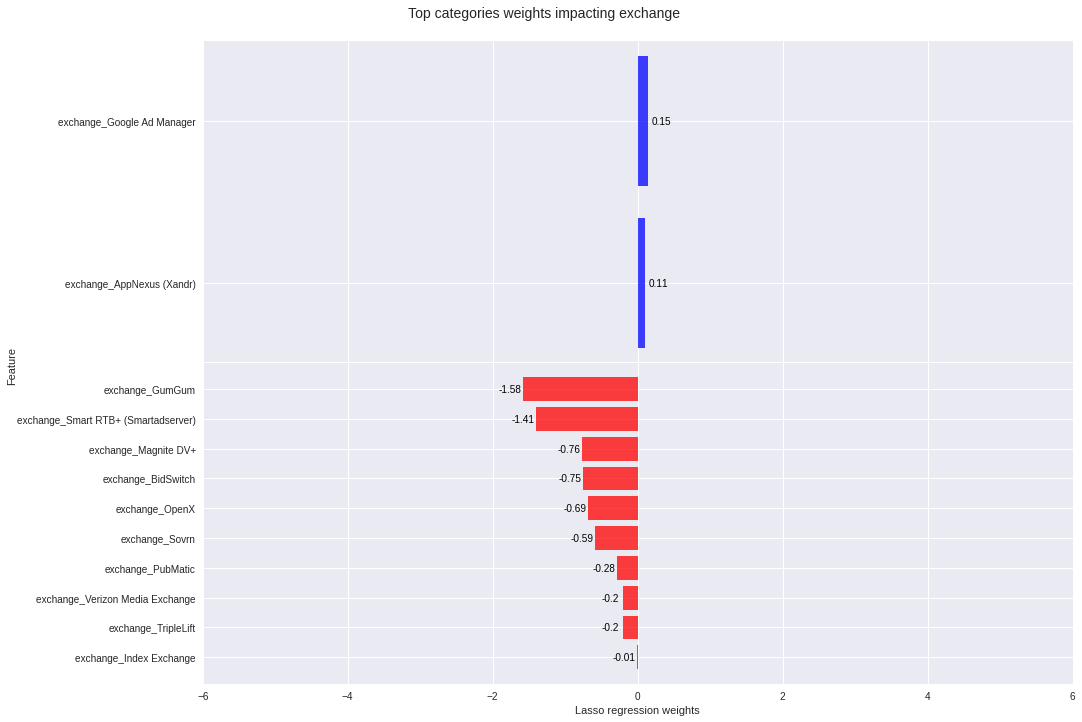

In [129]:
dimension_plot_deepdive('exchange')

In [137]:
# regularize features
dumped_f = dict(regularized_features['feature'])
dumped_f

{3: 'total_conversions',
 4: 'post_view_conversions',
 52: 'line_item_line_item20',
 65: 'line_item_line_item32',
 66: 'line_item_line_item33',
 67: 'line_item_line_item34',
 71: 'line_item_line_item7',
 78: 'device_make_Amazon (All Models)',
 79: 'device_make_Amlogic (All Models)',
 81: 'device_make_Archos (All Models)',
 83: 'device_make_BlackBerry (All Models)',
 84: 'device_make_Chuwi (All Models)',
 85: 'device_make_Cube (All Models)',
 88: 'device_make_Eken (All Models)',
 89: 'device_make_Evertek (All Models)',
 90: 'device_make_General Mobile (All Models)',
 92: 'device_make_Gionee (All Models)',
 96: 'device_make_IMO (All Models)',
 97: 'device_make_Karbonn (All Models)',
 98: 'device_make_Kyocera (All Models)',
 100: 'device_make_Lava (All Models)',
 102: 'device_make_Medion (All Models)',
 103: 'device_make_Meizu (All Models)',
 104: 'device_make_Micromax (All Models)',
 105: 'device_make_Microsoft (All Models)',
 107: 'device_make_Mozilla (All Models)',
 110: 'device_make_P

# Appendix


## A. Export regularized df

In [15]:
# Removing features regularized
X_regularized = X.drop(X.columns[feature_dump],axis=1)

# Split data set
X_train, X_test, y_train, y_test = train_test_split(X_regularized, y, test_size=0.15, random_state = seed, stratify = y)
print(F"X_train matrix: {X_train.shape}\ny_train vector:  {y_train.shape[0]}\nX_test matrix: {X_test.shape}\ny_test vector:  {y_test.shape[0]} ")

# transform train and test files to pickle form
export_files = {1:(X_train, 'X_train'), 2:(y_train,'y_train'), 3: (X_test,'X_test'), 4: (y_test,'y_test')}

for i in tqdm(export_files):
    sfile = bz2.BZ2File(path_feature + export_files[i][1] +'_regularized_w2_1pct', 'w') #'_w1_1pct'
    pickle.dump(export_files[i][0],sfile)
    sfile.close()

  0%|          | 0/4 [00:00<?, ?it/s]

X_train matrix: (338282, 189)
y_train vector:  338282
X_test matrix: (59697, 189)
y_test vector:  59697 


100%|██████████| 4/4 [00:12<00:00,  3.23s/it]


## B. Heteroskedasticity evaluation

In [ ]:
# Fit the regression model
fit = smf.ols('rating ~ points+runs+wickets', data=dataframe).fit()

# Conduct the Breusch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']

# Get the test result
test_result = sms.het_breuschpagan(fit.resid, fit.model.exog)

lzip(names, test_result)

In [165]:
# define list categorical and numerica features
numeric_cols = df_prep.select_dtypes(include=['int64', 'float64']).columns
catg_cols = df_prep.select_dtypes(include=['object']).columns

numeric_df = df_prep[numeric_cols]
numeric_df.drop(['user_response','index'],axis=1, inplace = True)

In [168]:
# Fit the regression model
fit = smf.ols('clicks ~ impressions+billable_impressions+viewable_impressions+total_conversions+post_view_conversions+media_cost_log+total_media_cost_log', data=numeric_df).fit()

# Conduct the Breusch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']

# Get the test result
test_result = sms.het_breuschpagan(fit.resid, fit.model.exog)

lzip(names, test_result)

#reference: https://www.geeksforgeeks.org/how-to-perform-a-breusch-pagan-test-in-python/

[('Lagrange multiplier statistic', 338.39306531929356),
 ('p-value', 3.755849973689683e-69),
 ('f-value', 67.73518651551844),
 ('f p-value', 5.146558079291049e-71)]

In [169]:
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 clicks   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     54.83
Date:                Tue, 28 Jun 2022   Prob (F-statistic):           3.72e-57
Time:                        01:21:58   Log-Likelihood:             8.8514e+05
No. Observations:              397979   AIC:                        -1.770e+06
Df Residuals:                  397973   BIC:                        -1.770e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.00

# Reference

https://www.geeksforgeeks.org/how-to-perform-a-breusch-pagan-test-in-python/